In [943]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

kundenDf = pd.read_csv('data/kunden.csv', sep = ';')
besucherDf = pd.read_csv('data/besucher.csv', sep = ';')
kundeBundesland = pd.read_csv('data/geo.txt', sep = '\t')

In [944]:
# Bereinigte Daten Bundesland
kundeBundesland['Niederlassung'] = kundeBundesland['Niederlassung'].replace({
    'Berlin-Charlottenburg': 'Berlin',
    'Berlin-Mitte': 'Berlin',
    'BERLIN': 'Berlin',
    'NRW': 'Nordrhein-Westfalen',
    'Düsseldorf': 'Nordrhein-Westfalen'
})

kundenDf['Besucher'] = 0
besucherDf['Besucher'] = 1

# Fasse die DataFrames zusammen
finaldf = pd.concat([kundenDf, besucherDf], ignore_index=True)

# Ersetze "," durch "." und runde auf zwei Nachkommastellen für "Einkommen"
finaldf['Einkommen'] = finaldf['Einkommen'].replace({',': '.'}, regex=True).astype(float).round(2)

# Runde auf zwei Nachkommastellen für "Preis"
finaldf['Preis'] = finaldf['Preis'].astype(float).round(2)

# Entferne Dezimalstellen für "Geschlecht" und konvertiere zu Ganzzahlen
finaldf['Geschlecht'] = finaldf['Geschlecht'].replace({',': '.'}, regex=True).astype(float)
finaldf['Geschlecht'] = finaldf['Geschlecht'].dropna().astype(int)

# Entferne Dezimalstellen für "Zeit" und konvertiere zu Ganzzahlen
finaldf['Zeit'] = finaldf['Zeit'].replace({',': '.'}, regex=True).astype(float).astype(int)

# Entferne Ausreißer aus der "Einkommen"-Spalte
finaldf['Einkommen'] = remove_outliers_iqr(finaldf['Einkommen'])

# Erstelle die "Kauf"-Spalte (1 für Kauf, 0 für Nicht-Kauf)
finaldf['Kauf'] = finaldf['Preis'].notna().astype(int)

finaldf = pd.merge(finaldf, kundeBundesland, on='KundeNr', how='inner')

# Gleiche Datentypen
finaldf = finaldf.astype({'Alter': 'int64', 'Zeit': 'int64', 'Kauf': 'int64'})

# Fill Na
einkommen_mode = finaldf['Einkommen'].mode()[0]
geschlecht_mode = finaldf['Geschlecht'].mode()[0]

finaldf['Einkommen'] = finaldf['Einkommen'].fillna(einkommen_mode)
finaldf['Geschlecht'] = finaldf['Geschlecht'].fillna(geschlecht_mode)

# Anzeige des resultierenden DataFrame
#print(finaldf)
#finaldf.isnull().sum()
finaldf.to_csv('data/finaldf.csv', index=False, sep = ';')

# Die Analyse des Elektroauto-Marktes: Kundenpräferenzen, sozioökonomische Merkmale und Kaufmotivation bei Elektratuto AG

# Gliederung
- Erfolgsfaktoren und Marktanalyse CEO
- Statistische Analysen
- Regressionsanalysen
- Probleme
- Empfehlungen fuer die Zukunft

# Erfolgsfaktoren und Marktanalyse

In [945]:
anzahl_kunden = (finaldf['Kauf'] == 1).sum()
print(f'- Gesamtanzahl der verkauften Autos: {anzahl_kunden}')

preis = finaldf['Preis']

max = round(preis.max(),2)
min = round(preis.min(),2)
mean = round(preis.mean(),2)

print(f'- Bei einem Hoechstpreis von = {max} Euro, \n Mindestpreis von = {min} Euro und Durchschnittspreis von = {mean} Euro')

sum = preis.sum().round(2)

print(f'- Es ergibt sich ein Gesamtumsatz von {sum} Euro')

- Gesamtanzahl der verkauften Autos: 1104
- Bei einem Hoechstpreis von = 165482.31 Euro, 
 Mindestpreis von = 21471.65 Euro und Durchschnittspreis von = 88975.2 Euro
- Es ergibt sich ein Gesamtumsatz von 98228619.38 Euro


Regionale Marktdurchdringung

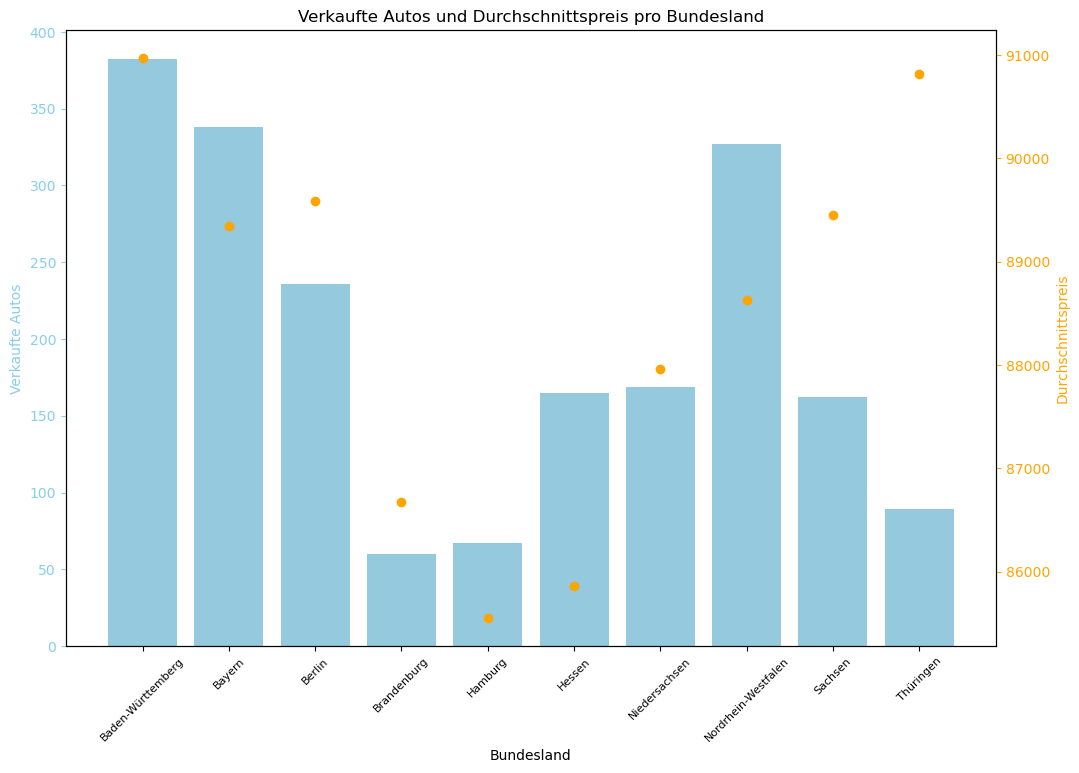

In [946]:
# Anzahl verkauften Autos
anzahl_autos_pro_bundesland = finaldf.groupby('Niederlassung')['KundeNr'].count().reset_index()
anzahl_autos_pro_bundesland.columns = ['Bundesland', 'VerkaufteAutos']

# Durchschnittlicher Umsatz
durchschnittsumsatz_pro_bundesland = finaldf.groupby('Niederlassung')['Preis'].mean().reset_index()
durchschnittsumsatz_pro_bundesland.columns = ['Bundesland', 'Durchschnittspreis']

ergebnisse_df = pd.merge(anzahl_autos_pro_bundesland, durchschnittsumsatz_pro_bundesland, on='Bundesland')

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x='Bundesland', y='VerkaufteAutos', data=ergebnisse_df, ax=ax1, color='skyblue')
ax1.set_ylabel('Verkaufte Autos', color='skyblue')
ax1.tick_params('y', colors='skyblue')

ax1.tick_params(axis='x', rotation=45, labelsize=8)

ax2 = ax1.twinx()
plt.plot(ergebnisse_df['Bundesland'], ergebnisse_df['Durchschnittspreis'], marker='o', linestyle='', color='orange')

ax2.set_ylabel('Durchschnittspreis', color='orange')
ax2.tick_params('y', colors='orange')

plt.title('Verkaufte Autos und Durchschnittspreis pro Bundesland')
plt.show()

Welche Merkmale der Kunden beeinflussen den Kaufpreis?

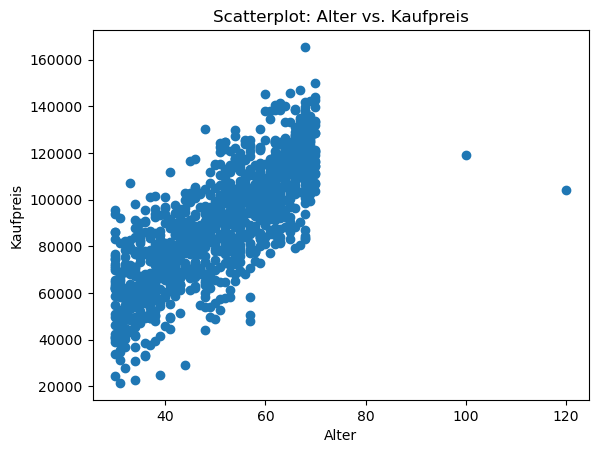

In [947]:
abhängige_variablen = ['Alter', 'Einkommen', 'Geschlecht', 'Zeit']

unabhängige_variablen = sm.add_constant(finaldf[abhängige_variablen])

# Zielvariable (abhängige Variable)
abhängige_variable = finaldf['Preis']

# Lineare Regression
modell = sm.OLS(abhängige_variable, unabhängige_variablen).fit()

unabhängige_variablen = unabhängige_variablen.dropna()

#modell.summary()

plt.scatter(finaldf['Alter'], finaldf['Preis'])
plt.xlabel('Alter')
plt.ylabel('Kaufpreis')
plt.title('Scatterplot: Alter vs. Kaufpreis')
plt.show()

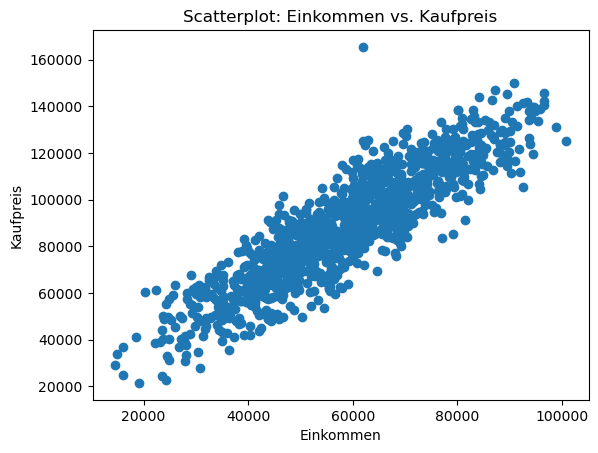

In [948]:
# Entfernt NaN-Werte aus den Spalten Einkommen und Preis
filtered_data = finaldf[['Einkommen', 'Preis']].dropna()

# Scatterplot mit den verbleibenden Werten
plt.scatter(filtered_data['Einkommen'], filtered_data['Preis'])
plt.xlabel('Einkommen')
plt.ylabel('Kaufpreis')
plt.title('Scatterplot: Einkommen vs. Kaufpreis')
plt.show()

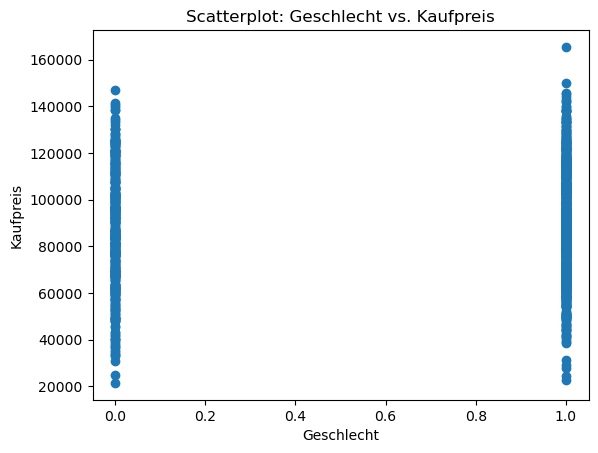

In [949]:
# Entfernt NaN-Werte aus den Spalten Geschlecht und Preis
filtered_data = finaldf[['Geschlecht', 'Preis']].dropna()

# Scatterplot mit den verbleibenden Werten
plt.scatter(filtered_data['Geschlecht'], filtered_data['Preis'])
plt.xlabel('Geschlecht')
plt.ylabel('Kaufpreis')
plt.title('Scatterplot: Geschlecht vs. Kaufpreis')
plt.show()

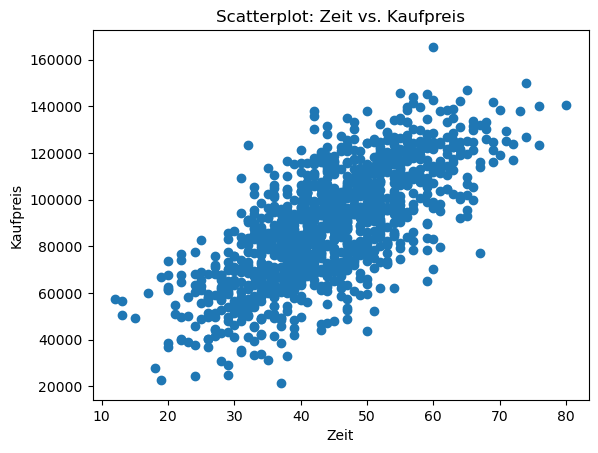

In [950]:
# Entfernt NaN-Werte aus den Spalten Zeit und Preis
filtered_data = finaldf[['Zeit', 'Preis']].dropna()

# Scatterplot mit den verbleibenden Werten
plt.scatter(filtered_data['Zeit'], filtered_data['Preis'])
plt.xlabel('Zeit')
plt.ylabel('Kaufpreis')
plt.title('Scatterplot: Zeit vs. Kaufpreis')
plt.show()

Geschlechtsverteilung der Kunden

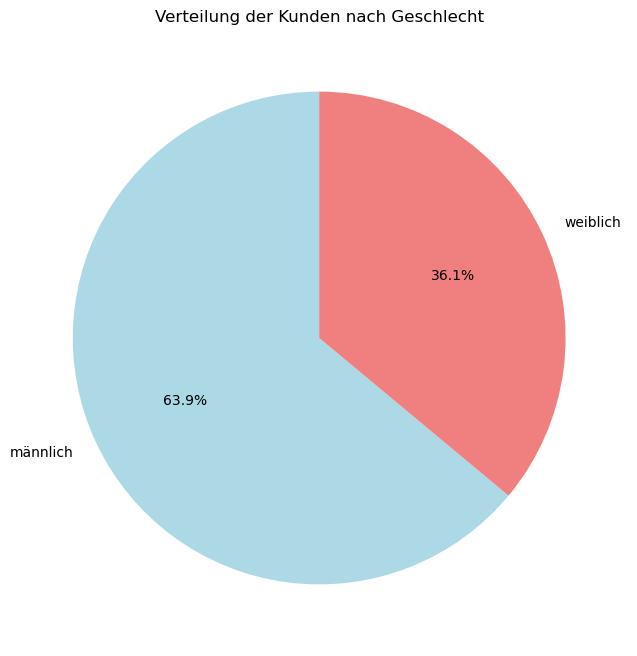

In [951]:
geschlechtConv = kundenDf
geschlechtConv['Geschlecht'] = finaldf['Geschlecht'].replace({0: 'weiblich', 1: 'männlich'})

geschlechtsverteilung = geschlechtConv.groupby(by='Geschlecht').count()

plt.figure(figsize=(8, 8))
plt.pie(geschlechtsverteilung['KundeNr'], labels=geschlechtsverteilung.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Verteilung der Kunden nach Geschlecht')
plt.show()

Durchschnittsalter der Kunden

In [952]:
kaufende_personen = finaldf[finaldf['Kauf'] == 1]
durchschnittsalter = kaufende_personen['Alter'].mean()
print(f'Das Durchschnittsalter unserer Kunden betraegt {durchschnittsalter.round(4)} Jahre, also rund {durchschnittsalter.round()} Jahre')

Das Durchschnittsalter unserer Kunden betraegt 50.4819 Jahre, also rund 50.0 Jahre


Durchschnittsalter der Besucher in Showrooms

In [953]:
besuchende_personen = finaldf[finaldf['Besucher'] == 1]
durchschnittsalterb = besuchende_personen['Alter'].mean()
print(f'Das Durchschnittsalter unserer Besucher betraegt {durchschnittsalterb.round(4)} Jahre, also rund {durchschnittsalterb.round()} Jahre')

Das Durchschnittsalter unserer Besucher betraegt 49.881 Jahre, also rund 50.0 Jahre


Durchschnittsalter der maennlichen Kunden

In [954]:
geschlechtConv[geschlechtConv['Geschlecht'] == 'männlich'][['Geschlecht', 'Alter']].groupby(by='Geschlecht').mean().round()

,Alter
Geschlecht,
männlich,51.0


Durchschnittseinkommen der Kunden

In [955]:
#kaufende_personen = finaldf[finaldf['Kauf'] == 1]
durchschnittseinkommen = kaufende_personen['Einkommen'].mean()
print(f'Das Durchschnittseinkommen unserer Kunden betraegt {durchschnittseinkommen.round(2)} Euro')

Das Durchschnittseinkommen unserer Kunden betraegt 58861.3 Euro


# Statistische Analysen

Abhaengigkeit zwischen Alter, Einkommen, Preis und Zeit

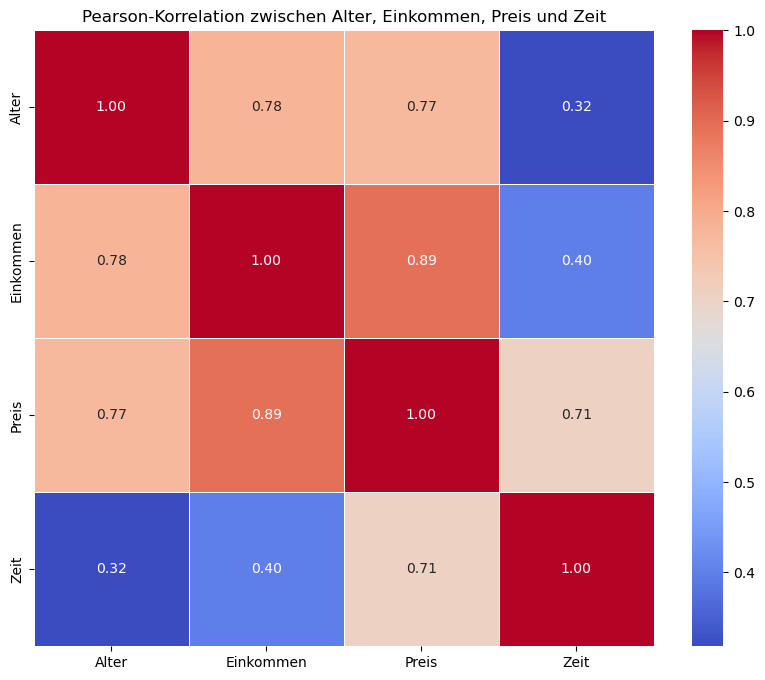

In [956]:
# Pearson-Korrelation
korrelation_matrix = finaldf[['Alter', 'Einkommen', 'Preis', 'Zeit']].corr(method='pearson')

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(korrelation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson-Korrelation zwischen Alter, Einkommen, Preis und Zeit')
plt.show()

Wie viel Zeit verbringen Kunden und Besucher bei uns?

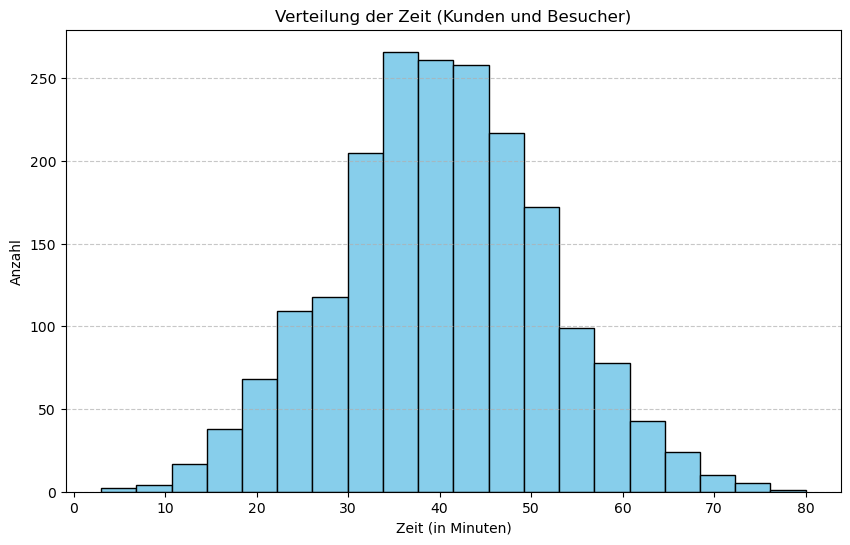

In [957]:
plt.figure(figsize=(10, 6))
plt.hist(finaldf['Zeit'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Verteilung der Zeit (Kunden und Besucher)')
plt.xlabel('Zeit (in Minuten)')
plt.ylabel('Anzahl')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Kunden mit Krediten

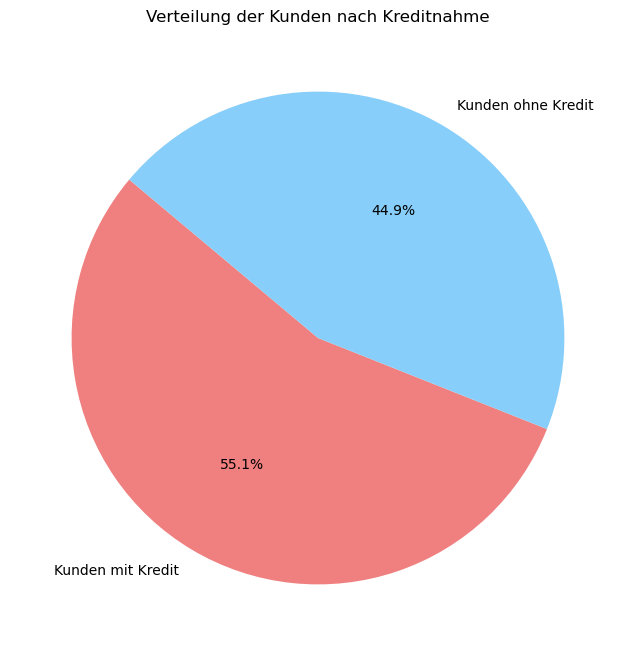

In [958]:
finaldf['Kredit genommen'] = (finaldf['Einkommen'] <= finaldf['Preis']).astype(int)

anzahl_kunden_mit_kredit = finaldf['Kredit genommen'].value_counts().get(1, 0)
anzahl_kunden_ohne_kredit = finaldf['Kredit genommen'].value_counts().get(0, 0)

# Diagramm
labels = ['Kunden mit Kredit', 'Kunden ohne Kredit']
sizes = [anzahl_kunden_mit_kredit, anzahl_kunden_ohne_kredit]
colors = ['lightcoral', 'lightskyblue']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Verteilung der Kunden nach Kreditnahme')
plt.show()

# Regressionsanalysen

Prognostizierter Kaufpreis eines unserer Autos

In [959]:
features = ['Alter', 'Einkommen', 'Geschlecht']

# Filtere nach "Kauf" == 1 und entferne NaN-Werte aus den relevanten Spalten
filterP_finaldf = finaldf[finaldf['Kauf'] == 1].dropna(subset=['Preis'] + features)

# X: Unabhängige Variablen, y: Abhängige Variable (Preis)
X = filterP_finaldf[features].values
y = filterP_finaldf['Preis'].values

# Modell initialisieren und trainieren
model = LinearRegression()
model.fit(X, y)

# Prognose für den ersten Kunden (Alter: 32, Einkommen: 30.000, Geschlecht: männlich)
kunde1 = np.array([[32, 30000, 1]])  # Umwandlung in NumPy-Array
kaufpreis1 = model.predict(kunde1)
print(f"Prognostizierter Kaufpreis fuer einen Kunden (Alter: 32, Einkommen: 30.000, Geschlecht: maennlich): {kaufpreis1[0]:.2f} Euro")

# Prognose für den zweiten Kunden (Alter: 51, Einkommen: 54.000, Geschlecht: männlich)
kunde2 = np.array([[51, 54000, 1]])  # Umwandlung in NumPy-Array
kaufpreis2 = model.predict(kunde2)
print(f"Prognostizierter Kaufpreis fuer einen Kunden (Alter: 51, Einkommen: 54.000, Geschlecht: maennlich): {kaufpreis2[0]:.2f} Euro")

Prognostizierter Kaufpreis fuer einen Kunden (Alter: 32, Einkommen: 30.000, Geschlecht: maennlich): 50433.24 Euro
Prognostizierter Kaufpreis fuer einen Kunden (Alter: 51, Einkommen: 54.000, Geschlecht: maennlich): 84826.82 Euro


Welche Variable beeinflusst den Preis am meisten?

In [960]:
# Erstelle Dummy-Variablen für das Geschlecht
final_dummie = pd.get_dummies(finaldf, columns=['Geschlecht'], drop_first=True)

# Definiere die Features und die abhängige Variable
features = ['Alter', 'Einkommen', 'Geschlecht']  # Falls 'Geschlecht' durch get_dummies in 'Geschlecht_1' umbenannt wurde
dependent_variable = 'Preis'

# Filtere nach "Kauf" == 1 und entferne NaN-Werte aus den relevanten Spalten
filtered_finaldf = finaldf[finaldf['Kauf'] == 1].dropna(subset=[dependent_variable] + features)

# X: Unabhängige Variablen, y: Abhängige Variable (Preis)
X = filtered_finaldf[features]
y = filtered_finaldf[dependent_variable]

# Modell initialisieren und trainieren
model = LinearRegression()
model.fit(X, y)

# Beta-Werte abrufen
beta_values = model.coef_

for feature, beta in zip(features, beta_values):
    print(f"{feature}: {beta:.4f}")

# Die Variable mit dem größten Einfluss ermitteln
max_influencing_variable = features[abs(beta_values).argmax()]
print(f'\nHierbei beeinflusst folgende Variable den Preis am meisten: {max_influencing_variable}')

Alter: 461.9775
Einkommen: 1.0673
Geschlecht: 2221.5505

Hierbei beeinflusst folgende Variable den Preis am meisten: Geschlecht


Mit welcher Wahrscheinlichkeit wird bei uns ein Auto gekauft?

In [961]:
# Dummy-Kodierung für Geschlecht (falls nicht bereits vorhanden)
#finaldf = pd.get_dummies(finaldf, columns=['Geschlecht'], drop_first=True)

# Definieren der Features
features = ['Alter', 'Einkommen', 'Geschlecht']

# X: Unabhängige Variablen, y: Binäre Abhängige Variable (Kauf: 1 oder Nicht-Kauf: 0)
X = finaldf[features]
y = finaldf['Kauf']

# Hinzufügen einer Konstanten für den Intercept-Term
X = sm.add_constant(X)

# Modell initialisieren und schätzen
model = sm.Logit(y, X)
result = model.fit()

# Anzeige der Zusammenfassung des Modells
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.683525
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   Kauf   No. Observations:                 1995
Model:                          Logit   Df Residuals:                     1991
Method:                           MLE   Df Model:                            3
Date:                Wed, 10 Jan 2024   Pseudo R-squ.:                0.005691
Time:                        21:22:21   Log-Likelihood:                -1363.6
converged:                       True   LL-Null:                       -1371.4
Covariance Type:            nonrobust   LLR p-value:                  0.001364
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0887      0.204     -0.435      0.664      -0.489       0.311
Alter          0.0163      0.

Mit welcher Wahrscheinlichkeit wird bei uns ein getestetes Auto gekauft?

In [962]:
# Definieren der Features
features = ['Alter', 'Einkommen', 'Geschlecht', 'Zeit']

# X: Unabhängige Variablen, y: Binäre Abhängige Variable (Kauf: 1 oder Nicht-Kauf: 0)
X = finaldf[features]
y = finaldf['Kauf']

# Normalisierung der Daten
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

# Modell initialisieren und trainieren
model = LogisticRegression()
model.fit(X_scaled, y)

# Funktion zur Berechnung der Wahrscheinlichkeit eines Kaufs
def wahrscheinlichkeit_kauf(model, daten):
    daten_scaled = scaler.transform(daten.values)
    proba = model.predict_proba(daten_scaled)[:, 1]
    return proba

# Beispiel-Kunden
kunde1 = pd.DataFrame([[32, 30000, 1, 30]], columns=features)
kunde2 = pd.DataFrame([[51, 54000, 1, 45]], columns=features)

# Wahrscheinlichkeiten berechnen
wahrscheinlichkeit1 = wahrscheinlichkeit_kauf(model, kunde1)
wahrscheinlichkeit2 = wahrscheinlichkeit_kauf(model, kunde2)

print(f"Kaufwahrscheinlichkeit fuer Kunden (Alter: 32, Einkommen: 30.000, Geschlecht: maennlich, Zeit: 30 Minuten): {wahrscheinlichkeit1[0]:.2%}")
print(f"Kaufwahrscheinlichkeit fuer Kunden (Alter: 51, Einkommen: 54.000, Geschlecht: maennlich, Zeit: 45 Minuten): {wahrscheinlichkeit2[0]:.2%}")

Kaufwahrscheinlichkeit fuer Kunden (Alter: 32, Einkommen: 30.000, Geschlecht: maennlich, Zeit: 30 Minuten): 54.72%
Kaufwahrscheinlichkeit fuer Kunden (Alter: 51, Einkommen: 54.000, Geschlecht: maennlich, Zeit: 45 Minuten): 73.91%


# Probleme

Probleme
- Unterschiedliche Formate in den Daten zB Geschlecht als 1.0 und 1

# Empfelungen fuer die Zukunft

Empfelungen fuer die Zukunft
- Einheitliche Datentypen

# Vielen Dank fuer eure Aufmerksamkeit

jupyter nbconvert presentation2.ipynb --to slides --no-input --stdout > index.html